# 부동산 경매 낙찰가 예측 과제

# 0. 비즈니스 목적 이해

#### 간단합니다. 경매 낙찰 예상가를 예측하는 것입니다.
사실 경매는 암흑의 장막 속에서 손을 뻗는 것과 같습니다. 아무것도 모르는 상태에서 눈치를 보며 입찰가를 내야 하는데, 이게 때로는 엄청난 손해를 볼 수도, 엄청난 이득을 볼 수도 있습니다.

하지만 보통의 사람들도 이런 저런 정보들을 조합하여 입찰가를 냅니다. 즉, 패턴이 노출됩니다.

이러한 패턴을 머신러닝을 활용하여 예측 모델을 만들 수 있다면, 적정가를 통해서 물건을 낙찰 받을 수 있을 것입니다.

## 0.1 평가 기준
 - RMSE

In [220]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# 이거는 자꾸 맷플롯립 그래프에서 한글이 깨지는 문제로 폰트 설치해주는 코드

from matplotlib import font_manager, rc

font = r"C:\Users\thinp\fonts\NanumGothic.ttf"
font = font_manager.FontProperties(fname=font).get_name()
plt.style.use('seaborn-white')
rc('font', family=font)

In [3]:
tr = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_master_train.csv")
te = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_master_test.csv")
reg = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_regist.csv")
ren = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_rent.csv")
res = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_result.csv")
sub = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_submission.csv")

In [4]:
tr.shape, te.shape, reg.shape, ren.shape, res.shape, sub.shape

((1933, 41), (829, 41), (20702, 7), (1556, 8), (8528, 6), (829, 2))

In [5]:
pd.set_option('display.max_columns', tr.shape[0]+1)

## 0.2. 데이터 이해

#### Train Data Columns Describtion

    - Auction_key : 경매 아파트 고유 키 값
    - Auction_class : 경매구분; 강제=소송으로 진행 / 임의= 등기부등본 담보권으로 진행
    - Bid_class : 입찰 구분(일반/개별/일괄)
    - Claim_price : 경매 신청인의 청구 금액
    - Appraisal_company	: 감정사
    - Appraisal_date : 감정일자
    - Auction_count : 총 경매 횟수
    - Auction_miscarriage_count : 총 유찰 횟수
    
    
    - Total_land_gross_area : 총토지전체면적(㎡)
    - Total_land_real_area : 총토지실면적(㎡)
    - Total_land_auction_area : 총토지경매면적(㎡)
    - Total_building_area : 총건물면적(㎡)
    - Total_building_auction_area : 총건물경매면적(㎡)
    - Total_appraisal_price : 총 감정가 
    - Minimum_sales_price : 최저매각가격, 입찰 시 입찰인이 최저로 제시해야만 하는 금액 
    - First_auction_date : 최초 경매일
    - Final_auction_date : 최종 경매일
    - Final_result : 최종 결과
    
    
    - Creditor : 채권자, 경매 신청인
    - addr_do : 주소_시도
    - addr_si : 주소_시군구 
    - addr_dong : 주소_읍면동 
    - addr_li : 주소_리
    - addr_san : 산번지 여부(21개 뿐이며, 산이어도 전부 아파트입니다.)
    - addr_bunji1 : 번지1
    - addr_bunji2 : 번지2
    - addr_etc : 기타주소
    
    
    - Apartment_usage : 대표 용도 
    - Preserve_regist_date : 보존등기일, 건물을 신축하고 처음으로 등기
    - Total_floor : 총 층수 
    - Current_floor	: 현재 층수 
    - Specific : 특이사항
    - Share_auction_YorN : 지분경매여부
    - road_name	: 도로명 
    - road_bunji1 : 도로명 번지1
    - road_bunji2 : 도로명 번지2
    
    - Close_date : 종국일자
    - Close_result : 종국결과; 배당 후 종결
    - point.y : 위도 
    - point.x : 경도 
    
    
    - Hammer_price : 낙찰가

In [5]:
tr.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,836000000,668800000,2018-02-13 00:00:00,2018-03-20 00:00:00,낙찰,베리타스자산관리대부,부산,해운대구,우동,NaN,N,1398.0,NaN,해운대엑소디움 5층 101-502호,주상복합,2009-07-14 00:00:00,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,1073000000,858400000,2016-12-29 00:00:00,2017-02-02 00:00:00,낙찰,흥국저축은행,부산,해운대구,우동,NaN,N,1407.0,NaN,해운대두산위브더제니스 103동 51층 5103호,아파트,2011-12-16 00:00:00,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,119000000,76160000,2017-07-28 00:00:00,2017-10-13 00:00:00,낙찰,국민은행,부산,사상구,모라동,NaN,N,552.0,NaN,백양그린 206동 14층 1403호,아파트,1992-07-31 00:00:00,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,288400000,230720000,2017-07-20 00:00:00,2017-11-02 00:00:00,낙찰,고려저축은행,부산,남구,대연동,NaN,N,243.0,23.0,대연청구 109동 11층 1102호,아파트,2001-07-13 00:00:00,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,170000000,136000000,2016-07-06 00:00:00,2016-08-03 00:00:00,낙찰,Private,부산,사하구,괴정동,NaN,N,399.0,2.0,동조리젠시 7층 703호,아파트,2001-11-27 00:00:00,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


In [6]:
reg.head(3)

,Auction_key,Auction_seq,Regist_type,Regist_class,Regist_date,Creditor,Regist_price
0,1,10001,집합건물등기,소유이전,20050715,Private,0
1,1,10002,집합건물등기,가압,20050914,푸른이상호저축은행,860547945
2,1,10003,집합건물등기,가압,20051229,Private,189800000


In [7]:
ren.head(3)

,Auctiuon_key,Rent_class,Purpose_use,Occupied_part,Rent_date,Rent_deposit,Rent_monthly_price,Specific
0,1,전입,주거,201호전부,2007-09-14 00:00:00,53000000,250000,점유: 2007.09.14-\r\n조사서상:5300만
1,2,전입,주거,방3,2008-06-27 00:00:00,60000000,0,점유: 2005.09.12-
2,2,점유,주거,202호,1111-11-11 00:00:00,0,0,조사서상


In [8]:
res.head(3)

,Auction_key,Auction_seq,Auction_date,Appraisal_price,Minimum_sales_price,Auction_results
0,1,1,2011-06-21 00:00:00,313000000,313000000,변경
1,1,2,2011-12-13 00:00:00,313000000,313000000,변경
2,1,3,2016-05-17 00:00:00,298000000,298000000,유찰


## reg, ren, res 데이터를 살펴본 결과 해당 데이터셋에 대한 해석은 다음과 같다.

 - reg : 해당 물건의 등기부등본
     - 본 데이터는 기각이다. 이유는 아래와 같다.
         - 이미 경매로 넘어간 물건은 저당이 잡히거나, 소송에 걸린 건이기 때문에 Regist_class는 의미가 없다.
         - Regist_price 또한 저당 금액, 가압 금액 등의 편차가 크므로 오히려 과적합 될 우려가 있다.
         - 무엇보다도 Hammer Price와 비교하여 큰 상관관계를 보이지 않는다.
 
 
 - ren : 해당 물건의 rent 관련 기록
     - 본 데이터도 기각이다. 이유는 아래와 같다.
         - rent 관련 기록은 유의미하다. 전월세 환산 보증금을 통해 전세가율을 계산해서 시세를 유추할 수 있는 것은 맞다.
         - 그러나, 해당 데이터를 보면 방으로 되어 있는 것도 있고, 0으로 되어 있는 것도 있고 품이 매우 많이 든다.
         - 만약 쓴다면, 1% 를 올리기 위한 최후의 수단으로 놔둔다. 
         
         
 - res : 해당 물건의 경매 기록
     - 본 데이터도 기각이다. 이유는 아래와 같다.
         - 일단 해당 데이터는 이미 마스터 데이터에 있다. 뽑아낼 수 있는 것은 유찰 횟수이다.
         - 그러나 유찰이 되었다고 해서 경매가가 무조건 내려가지 않는다. 선형관계가 아니다.
         - 데이터를 통해서 상관관계를 찾아볼 수 있겠지만, 이 또한 1%를 올리기 위한 최후의 수단으로 놔둔다.
 
 


In [9]:
sub

,Auction_key,Hammer_price
0,1778,0
1,1779,0
2,1784,0
3,1786,0
4,1790,0
...,...,...
824,1762,0
825,1767,0
826,1770,0
827,1772,0


- "Auction_key" 에 맞춰서 Hammer_price를 예측해서 내면 되는 것이다.

## 시작하기 전에 심심풀이로 제출 한 번 해볼까요?

In [81]:
# 가장 중요하다고 생각되는 칼럼만으로 대충 분석 한 번 때려박아 보겠습니다.

tr_test = tr[["Auction_key", "Total_appraisal_price", "Minimum_sales_price", "addr_do", "Total_floor", "Current_floor", "Hammer_price"]]
te_test = te[["Auction_key", "Total_appraisal_price", "Minimum_sales_price", "addr_do", "Total_floor", "Current_floor", "Hammer_price"]]

# Total_appraisal_price	Minimum_sales_price 얘는 스케일링을 해주고,
# addr_do 이것은 라벨 인코딩 후 카테고리로 바꿔주고
# Total_floor	Current_floor	얘들은 그냥 라벨 인코딩만 해줄게요.

In [83]:
le = LabelEncoder()

le_columns = ["addr_do", "Total_floor", "Current_floor"]

for col in le_columns:
    tr_test[col] = le.fit_transform(tr_test[col])
    te_test[col] = le.fit_transform(te_test[col])

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [84]:
tr_test["addr_do"] = tr_test["addr_do"].astype('category')
te_test["addr_do"] = te_test["addr_do"].astype('category')

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


자 머신러닝 돌려봅시다.

In [87]:
features=['Auction_key', 'Total_appraisal_price', 'Minimum_sales_price',
       'addr_do', 'Total_floor', 'Current_floor']

label = ['Hammer_price']

In [88]:
X_train = tr_test[features]
y_train = tr_test[label]
X_test = te_test[features]
y_test = te_test[["Auction_key", "Hammer_price"]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1933, 6), (1933, 1), (829, 6), (829, 2))

In [89]:
# best_params_를 통해서 나온 값을 투입
rf_test2 = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=200,
                           random_state=1217,
                           n_jobs=-1)

#학습 
rf_test2.fit(X_train,y_train)

#예측값 생성
y_test['Hammer_price'] = rf_test2.predict(X_test)

# csv 파일로 내보낸다
y_test.to_csv(r"C:\Users\thinp\python\Kaggle\_check_points\Dacon_RealEstate_RFtest2.csv",index=False) 

# 비교를 위해 간단히 스코어를 추출한다.
rf_test.score(X_train, y_train)

# RMSE = 81,934,076 가 나왔습니다. 8천 2백만원 정도 오차가 나나보네요.
# 가채점 81 등입니다. 그냥 기본 변수 몇개만 넣었는데도 이렇네요?! 나쁘지 않습니다. 1등은 3천만원 수준입니다.

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


-172.90127563343154

# 1. 데이터 전처리 및 EDA

본격적으로 데이터 여행을 떠나봅시다. 칼럼을 하나 하나 전처리 하면서 꾹꾹 눌러서 살펴보겠습니다.

In [10]:
tr.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,836000000,668800000,2018-02-13 00:00:00,2018-03-20 00:00:00,낙찰,베리타스자산관리대부,부산,해운대구,우동,NaN,N,1398.0,NaN,해운대엑소디움 5층 101-502호,주상복합,2009-07-14 00:00:00,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,1073000000,858400000,2016-12-29 00:00:00,2017-02-02 00:00:00,낙찰,흥국저축은행,부산,해운대구,우동,NaN,N,1407.0,NaN,해운대두산위브더제니스 103동 51층 5103호,아파트,2011-12-16 00:00:00,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,119000000,76160000,2017-07-28 00:00:00,2017-10-13 00:00:00,낙찰,국민은행,부산,사상구,모라동,NaN,N,552.0,NaN,백양그린 206동 14층 1403호,아파트,1992-07-31 00:00:00,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,288400000,230720000,2017-07-20 00:00:00,2017-11-02 00:00:00,낙찰,고려저축은행,부산,남구,대연동,NaN,N,243.0,23.0,대연청구 109동 11층 1102호,아파트,2001-07-13 00:00:00,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,170000000,136000000,2016-07-06 00:00:00,2016-08-03 00:00:00,낙찰,Private,부산,사하구,괴정동,NaN,N,399.0,2.0,동조리젠시 7층 703호,아파트,2001-11-27 00:00:00,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


In [11]:
tr.isnull().sum()

Auction_key                       0
Auction_class                     0
Bid_class                         0
Claim_price                       0
Appraisal_company                 0
Appraisal_date                    0
Auction_count                     0
Auction_miscarriage_count         0
Total_land_gross_area             0
Total_land_real_area              0
Total_land_auction_area           0
Total_building_area               0
Total_building_auction_area       0
Total_appraisal_price             0
Minimum_sales_price               0
First_auction_date                0
Final_auction_date                0
Final_result                      0
Creditor                          0
addr_do                           0
addr_si                           0
addr_dong                         0
addr_li                        1910
addr_san                          0
addr_bunji1                       4
addr_bunji2                    1044
addr_etc                          0
Apartment_usage             

In [12]:
te.isnull().sum()

Auction_key                      0
Auction_class                    0
Bid_class                        0
Claim_price                      0
Appraisal_company                0
Appraisal_date                   0
Auction_count                    0
Auction_miscarriage_count        0
Total_land_gross_area            0
Total_land_real_area             0
Total_land_auction_area          0
Total_building_area              0
Total_building_auction_area      0
Total_appraisal_price            0
Minimum_sales_price              0
First_auction_date               0
Final_auction_date               0
Final_result                     0
Creditor                         0
addr_do                          0
addr_si                          0
addr_dong                        0
addr_li                        818
addr_san                         0
addr_bunji1                      1
addr_bunji2                    459
addr_etc                         0
Apartment_usage                  0
Preserve_regist_date

주소나 특이사항을 제외하고서는 결측치가 따로 없습니다. 깔끔하네요

### 1.01 Auction_class

 Auction_class : 경매구분; 강제=소송으로 진행 / 임의= 등기부등본 담보권으로 진행

In [21]:
tr["Auction_class"].value_counts()

임의    1439
강제     494
Name: Auction_class, dtype: int64

음, 일단 임의는 0, 강제는 1로 바꿔주겠습니다.

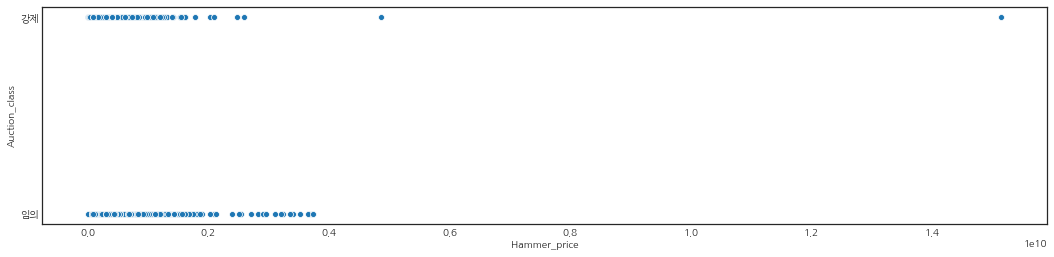

In [31]:
figure(figsize=(18,4))

sns.scatterplot(data=tr, y="Auction_class", x="Hammer_price")
plt.show()

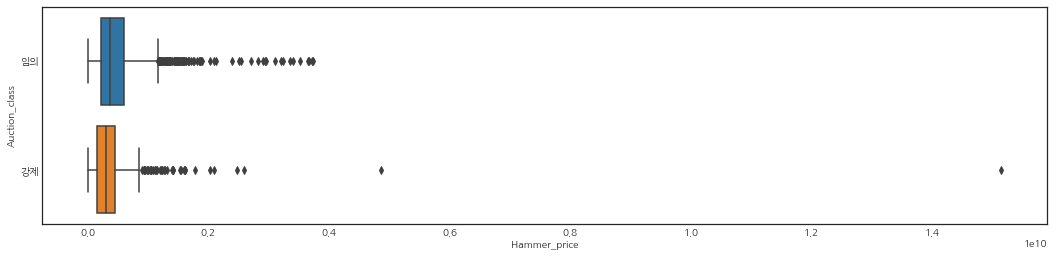

In [40]:
figure(figsize=(18,4))

sns.boxplot(data=tr, y="Auction_class", x="Hammer_price")
plt.show()

### 1.02 Bid_class

Bid_class : 입찰 구분(일반/개별/일괄)

In [23]:
tr["Bid_class"].value_counts()

일반    1796
개별     125
일괄      12
Name: Bid_class, dtype: int64

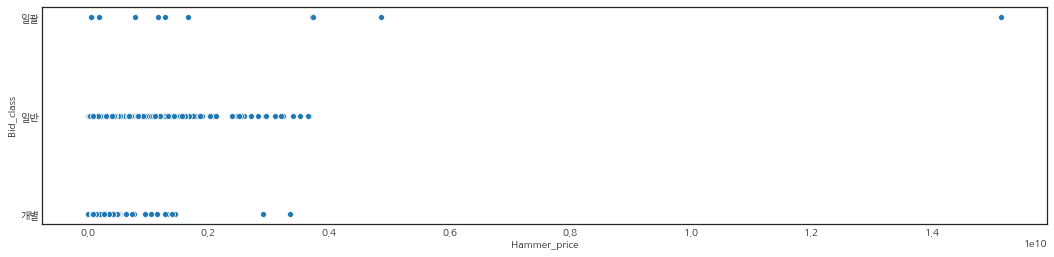

In [30]:
figure(figsize=(18,4))

sns.scatterplot(data=tr, y="Bid_class", x="Hammer_price")
plt.show()

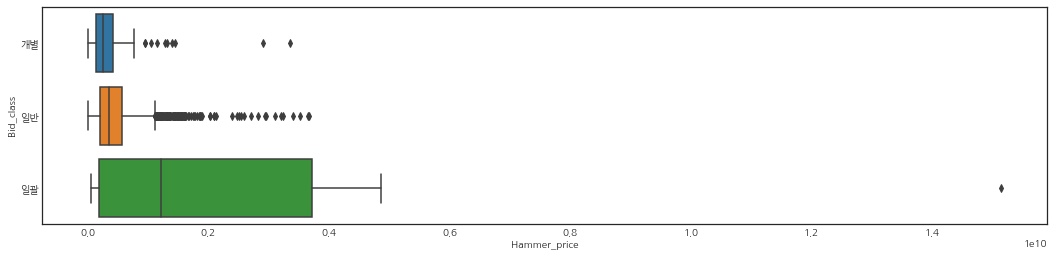

In [39]:
figure(figsize=(18,4))

sns.boxplot(data=tr,x="Hammer_price",  y="Bid_class")
plt.show()

### 1.03 Claim_price

Claim_price : 경매 신청인의 청구 금액

In [26]:
tr["Claim_price"].describe()

count    1.933000e+03
mean     3.703908e+08
std      1.337869e+09
min      0.000000e+00
25%      7.746112e+07
50%      1.728143e+08
75%      3.565089e+08
max      2.286481e+10
Name: Claim_price, dtype: float64

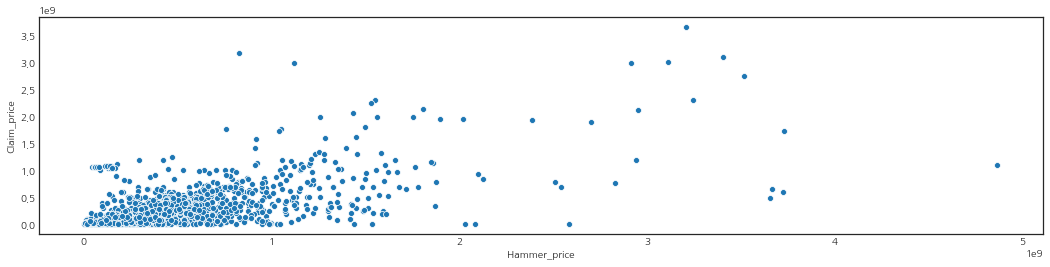

In [7]:
scatter = tr[tr["Hammer_price"] < 5000000000]
scatter = scatter[scatter["Claim_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="Claim_price", x="Hammer_price")
plt.show()

### 1.04 Appraisal_company

Appraisal_company : 감정사

In [41]:
tr["Appraisal_company"].value_counts() # 238개나 됩니다.

자연감정     33
부경감정     33
서초감정     31
대일감정     30
한마음감정    30
         ..
녹원감정      1
서울감정      1
YM감정      1
신화감정      1
온날감정      1
Name: Appraisal_company, Length: 238, dtype: int64

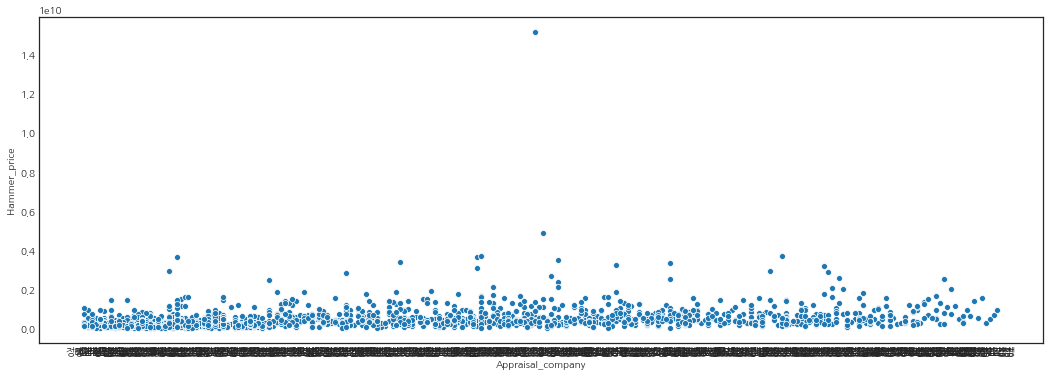

In [43]:
figure(figsize=(18,6))

sns.scatterplot(data=tr, x="Appraisal_company", y="Hammer_price")
plt.show()

이 칼럼을 쓰는 것이 과연 의미가 있는지에 대해 생각해봅시다.

### 1.05 Appraisal_date

Appraisal_date : 감정일자

In [44]:
tr["Appraisal_date"].value_counts()

2015-08-28 00:00:00    29
2016-10-24 00:00:00    16
2012-06-11 00:00:00    15
2015-12-02 00:00:00    12
2016-07-22 00:00:00    10
                       ..
2016-03-05 00:00:00     1
2014-04-14 00:00:00     1
2017-02-18 00:00:00     1
2016-06-16 00:00:00     1
2014-10-06 00:00:00     1
Name: Appraisal_date, Length: 712, dtype: int64

이 칼럼은 기간차이를 위해서 필요합니다. 감정 일자와 경매일자의 차이를 한 번 구해서 상관관계를 살펴보겠습니다.

### 1.06 Auction_count

In [46]:
tr["Auction_count"].value_counts()

2     1064
1      673
3      128
4       27
6       15
5       15
7        6
9        2
13       1
10       1
8        1
Name: Auction_count, dtype: int64

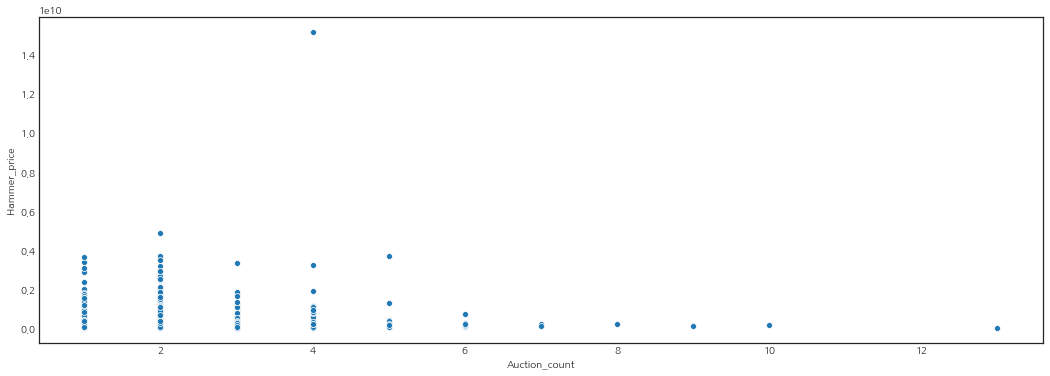

In [47]:
figure(figsize=(18,6))

sns.scatterplot(data=tr, x="Auction_count", y="Hammer_price")
plt.show()

4 번의 이상치만 제외하면 보통 숫자가 커질수록 낙찰가는 줄어드는군요.

### 1.07 Auction_miscarriage_count

Auction_miscarriage_count : 유찰 횟수

In [48]:
tr["Auction_miscarriage_count"].value_counts()

1    1088
0     685
2     106
3      26
5      14
6       6
4       6
9       1
7       1
Name: Auction_miscarriage_count, dtype: int64

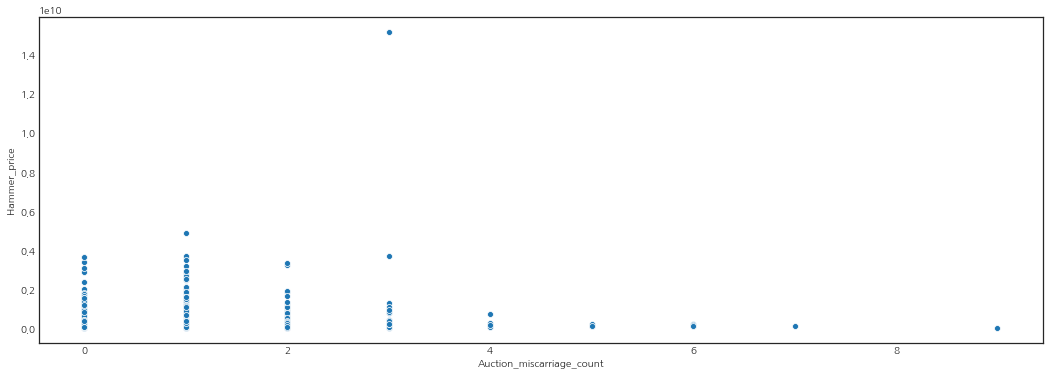

In [49]:
figure(figsize=(18,6))

sns.scatterplot(data=tr, x="Auction_miscarriage_count", y="Hammer_price")
plt.show()

놀랍군요! 역시나 앞의 경매 횟수와 매우 높은 다중공산성을 보일 것 같습니다. 하나를 버려야겠네요!

### 1.08 Total_land_gross_area

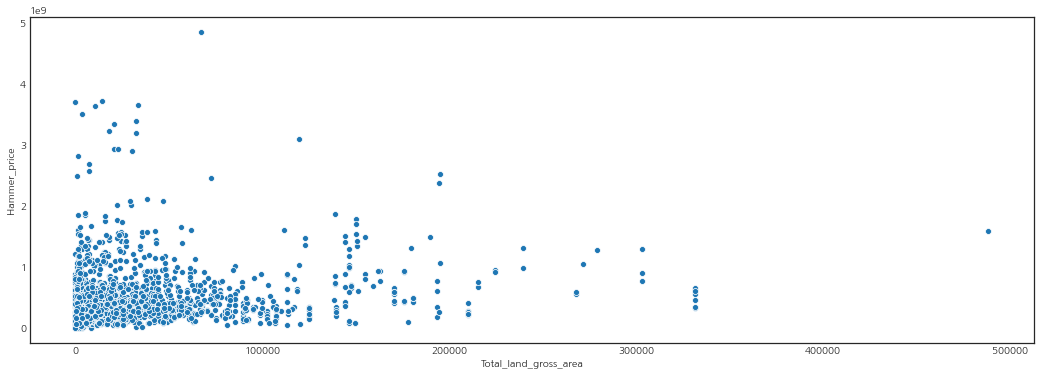

In [66]:
gross_area = tr[tr["Total_land_gross_area"] < 500000]
gross_area = gross_area[gross_area["Hammer_price"] < 5000000000]

figure(figsize=(18,6))

sns.scatterplot(data=gross_area, x="Total_land_gross_area", y="Hammer_price")
plt.show()

음 어떤 관계를 살펴보지 못하겠네요. 매우 방사형입니다. 역시 땅의 크기가 중요하기 보다는 평당 가격이 중요하겠죠?

어떤 지역의 땅인지가 더 중요할 것 같습니다.

### 1.09 Total_land_real_area

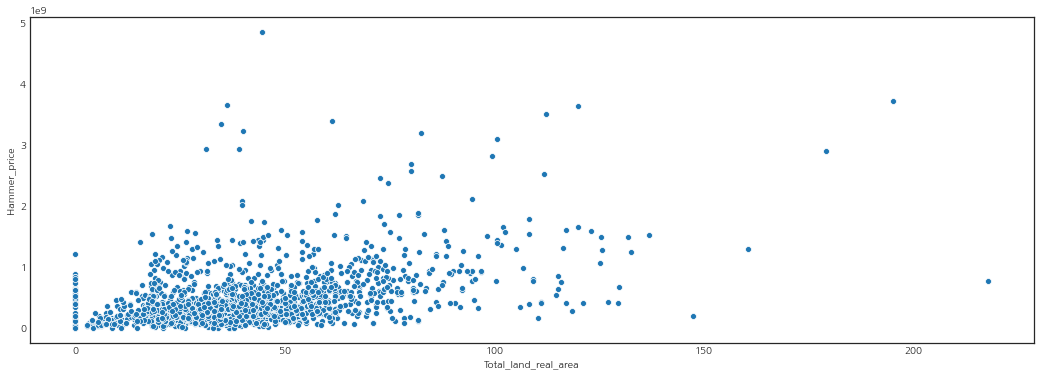

In [71]:
real_area = tr[tr["Total_land_real_area"] < 300]
#real_area = real_area[real_area["Hammer_price"] < 5000000000]

figure(figsize=(18,6))

sns.scatterplot(data=real_area, x="Total_land_real_area", y="Hammer_price")
plt.show()

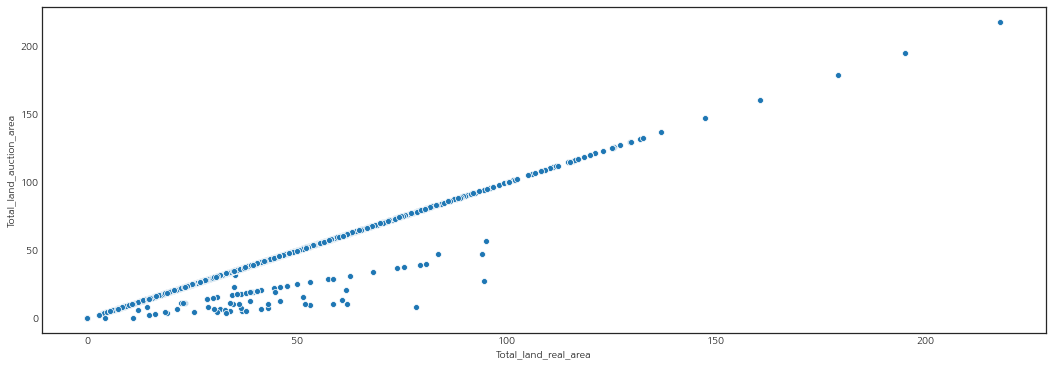

In [8]:
real_area = tr[tr["Total_land_real_area"] < 300]
#real_area = real_area[real_area["Hammer_price"] < 5000000000]

figure(figsize=(18,6))

sns.scatterplot(data=real_area, x="Total_land_real_area", y="Total_land_auction_area")
plt.show()

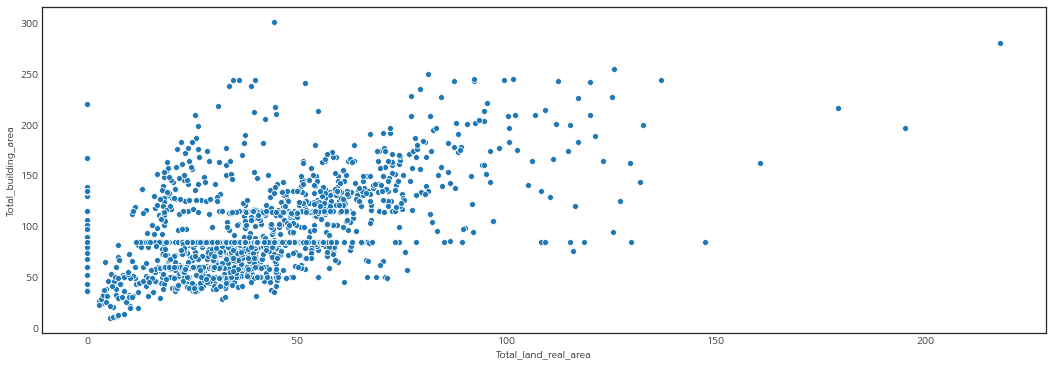

In [10]:
real_area = tr[tr["Total_land_real_area"] < 300]
#real_area = real_area[real_area["Hammer_price"] < 5000000000]

figure(figsize=(18,6))

sns.scatterplot(data=real_area, x="Total_land_real_area", y="Total_building_area")
plt.show()

토지 실면적이 0일 수가 있나요?! 실면적은 그래도 조금은 상관관계가 있어보입니다. 실면적이 0인 애들을 바꿔주는 게 중요할 것 같습니다.

### 1.10 Total_land_auction_area

토지경매면적은 토지전체면적과 비교를 해봐야겠습니다.

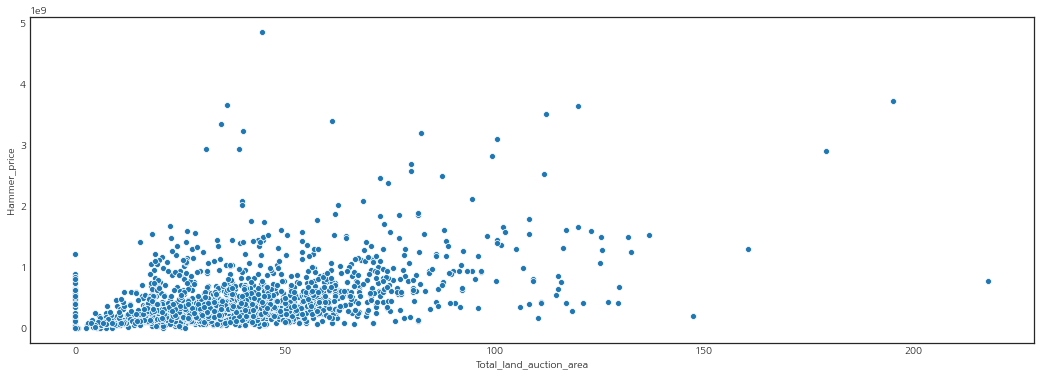

In [9]:
adj_area = tr[tr["Total_land_auction_area"] < 500]
adj_area = adj_area[adj_area["Total_land_gross_area"] < 500000]

figure(figsize=(18,6))

sns.scatterplot(data=adj_area, x="Total_land_auction_area", y="Hammer_price")
plt.show()

실제 경매 면적과 선형으로 증가하지 않네요. 총토지면적을 버리고 경매면적을 올려야 될 수도 있겠습니다.

### 1.11 Total_building_area ★

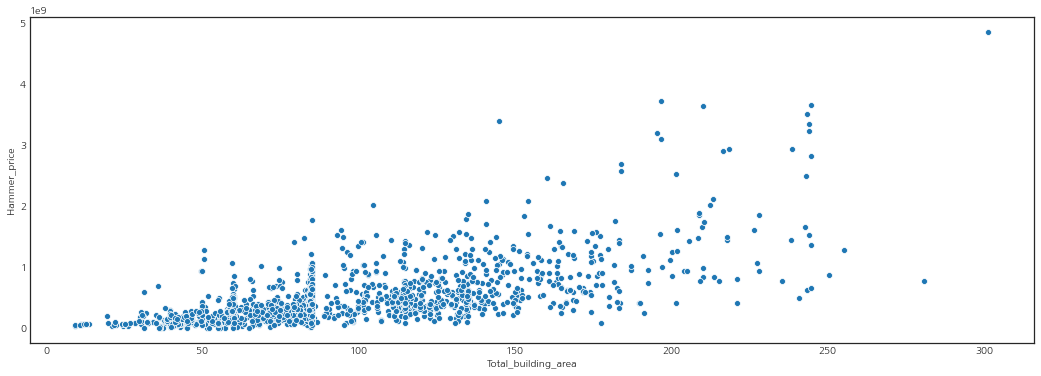

In [84]:
adj_area = tr[tr["Total_building_area"] < 500]
#adj_area = adj_area[adj_area["Total_land_gross_area"] < 500000]

figure(figsize=(18,6))

sns.scatterplot(data=adj_area, x="Total_building_area", y="Hammer_price")
plt.show()

이상치를 제외하고서는 꽤나 높은 선형 관계를 보이는 것 같습니다. 의미가 있겠습니다.

### 1.12 Total_building_auction_area

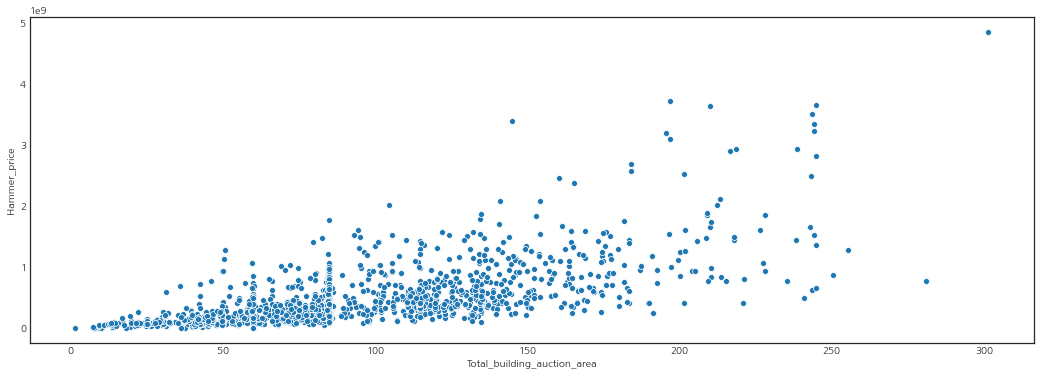

In [86]:
adj_area = tr[tr["Total_building_auction_area"] < 500]
#adj_area = adj_area[adj_area["Total_land_gross_area"] < 500000]

figure(figsize=(18,6))

sns.scatterplot(data=adj_area, x="Total_building_auction_area", y="Hammer_price")
plt.show()

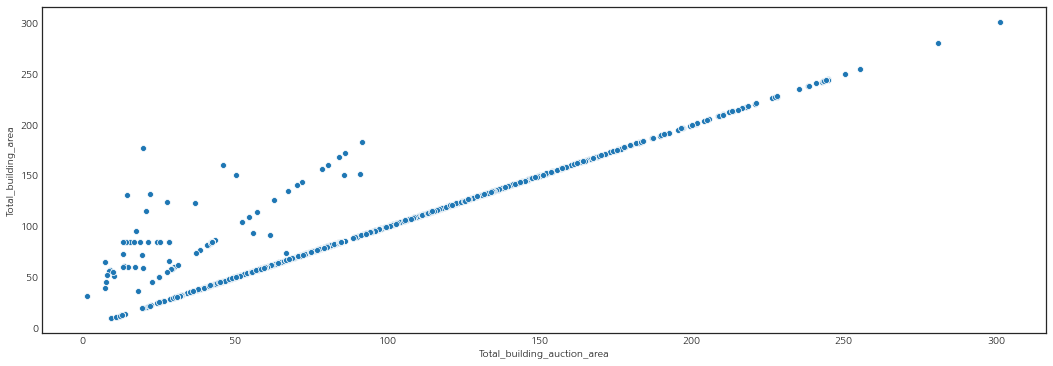

In [87]:
adj_area = tr[tr["Total_building_auction_area"] < 500]
#adj_area = adj_area[adj_area["Total_land_gross_area"] < 500000]

figure(figsize=(18,6))

sns.scatterplot(data=adj_area, x="Total_building_auction_area", y="Total_building_area")
plt.show()

거의 뭐 완벽하게 선형이네요. 역시 둘 중 하나만 선택해야겠습니다.

### 1.13 Total_appraisal_price

총 감정가입니다. 아주 중요한 변수라고 생각하고 있는데, 눈으로 확인해보겠습니다.

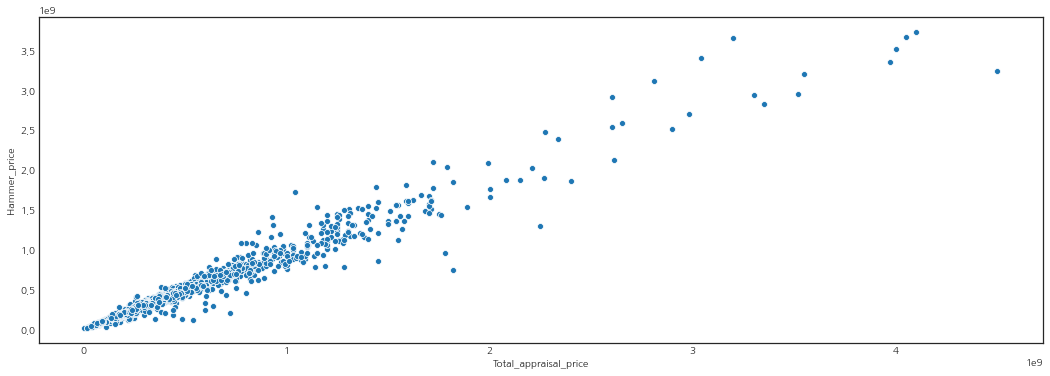

In [92]:
adj_tr = tr[tr["Total_appraisal_price"] < 5000000000]
#adj_area = adj_area[adj_area["Total_land_gross_area"] < 500000]

figure(figsize=(18,6))

sns.scatterplot(data=adj_tr, x="Total_appraisal_price", y="Hammer_price")
plt.show()

역시나 거의 완벽한 선형을 그립니다.

### 1.14 Minimum_sales_price

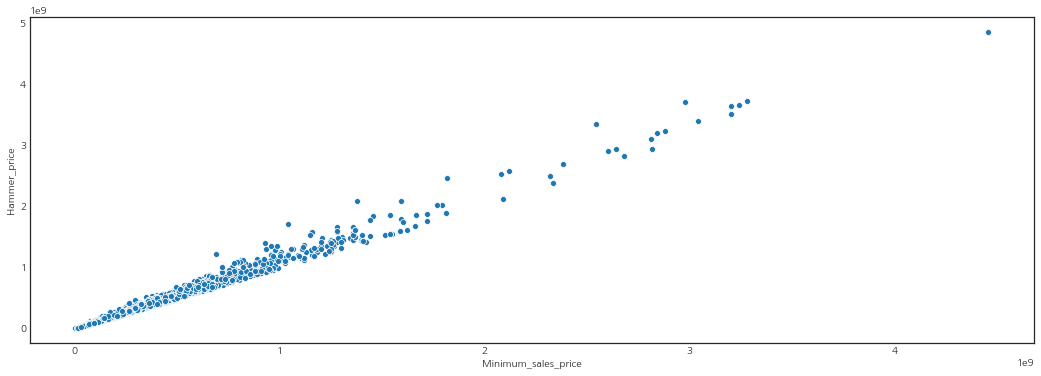

In [93]:
adj_tr = tr[tr["Minimum_sales_price"] < 5000000000]
#adj_area = adj_area[adj_area["Total_land_gross_area"] < 500000]

figure(figsize=(18,6))

sns.scatterplot(data=adj_tr, x="Minimum_sales_price", y="Hammer_price")
plt.show()

이건 더 완벽한 선형입니다.

### 1.15 First_auction_date, Final_auction_date

시작일과 종료일의 차이를 통해서 상관관계가 있는지 살펴보겠습니다.

In [41]:
# datetime 으로 바꿉니다.
tr['First_auction_date'] = pd.to_datetime(tr['First_auction_date'], errors='coerce')
tr['Final_auction_date'] = pd.to_datetime(tr['Final_auction_date'], errors='coerce')

# 서로 빼줍니다.
tr["auction_period"] =  tr["Final_auction_date"] - tr["First_auction_date"]

# 형변환해주고, 슬라이싱한 후 다시 인트로 형변환
tr["auction_period"]= tr["auction_period"].astype(str)
tr["auction_period"] = tr["auction_period"].apply(lambda x: x[:-24])
tr["auction_period"]= tr["auction_period"].astype(int)

# 밸류가 많으니 0일, 60일 이하, 그 이상으로 분류해줍니다.
new_auction_period = []
for i in range(len(tr["auction_period"])):
    if tr["auction_period"][i] == 0:
        new_auction_period.append(0)
    elif tr["auction_period"][i] < 60:
        new_auction_period.append(1)
    else:
        new_auction_period.append(2)

tr["new_auction_period"] = new_auction_period
tr["new_auction_period"].value_counts()

1    905
0    594
2    434
Name: new_auction_period, dtype: int64

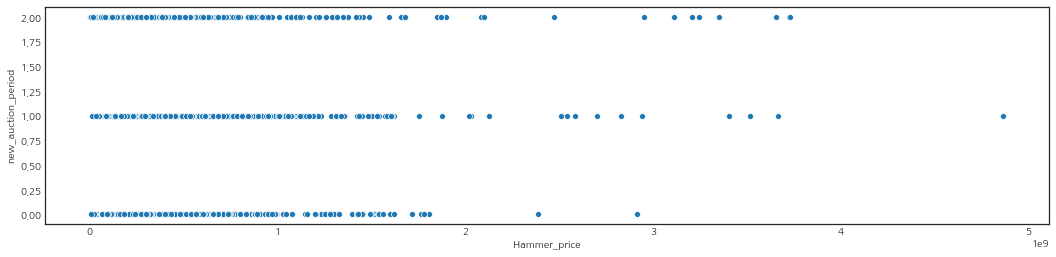

In [39]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="new_auction_period", x="Hammer_price")
plt.show()

크게 의미가 없어 보이는 것도 같은데, 1과 0에서 높은 값이 나오기도 하고..음 일단 만들어는 봅시다

### 1.16 Final_result

In [97]:
tr["Final_result"].value_counts() # 드랍하겠습니다.

낙찰    1933
Name: Final_result, dtype: int64

In [98]:
tr = tr.drop(["Final_result"], axis=1)

### 1.17 Creditor

In [108]:
tr["Creditor"].unique()

array(['베리타스자산관리대부', '흥국저축은행', '국민은행', '고려저축은행', 'Private', '서울보증보험',
       '천마(새)', '대형선망수협', '디에이치대부', '코카콜라음료', '한화저축은행', '프라임대부', '대부F&D',
       'HK저축은행', '부산은행', '농협은행', '청룡동(새)', '케이에이제7차유동화전문', '신용보증기금',
       '반야월농협', '제이티캐피탈', '오케이캐피탈대부', '우리은행', '대구은행', '삼성카드', '영진건설',
       '한화손해보험', '하나은행', '유진대부금융', '동부화재해상보험', '비에스금융대부', '(주)티베이',
       '범일5동(새)', '기술보증기금', '중소기업은행', '신한카드', '해운대신협', '승학(새)', '승학신협',
       '두산건설', '동래농협', '농협생명보험', '한국주택금융공사', '현대캐피탈', 'NH농협캐피탈', '신한생명보험',
       '동부산농협', '경북대구낙농협', '부영벽산아파트입주자대표회의', '한국씨티은행', 'KB국민카드', '디지비캐피탈',
       '베스트피플대부', '세종상호저축은행', '경남은행', '북부산(새)', '한국무역보험공사', '스카이저축은행',
       '에이치에스제일차유동화전문', '영우유통', '명륜동(새)', '구서2동(새)', '남천천신협', '부곡동(새)',
       '한화생명보험', '영남자원', '비엔케이캐피탈', '대양석유(주)', '부산주례(새)', '대청(새)',
       '중부(새)', '기술신용보증기금', '범일동(새)', '경산농협', '국제저축은행', '그랜드코리아레저',
       '부산동부신협', '신한은행', '웰릭스에프앤아이대부', '대구태영신협', '부산평화(새)', '진주서부농협',
       '감천1동(새)', '제1,2구잠수기수협', '농소농협', 'SC은행', '진해수협', '서1동(새)', '현대모비스',
    

에 뭐 은행, 재단, 대부, 농협, 캐피탈, 보험, 조합, 수협, 신협, 카드 등등 많습니다.

개인과 금융권, 기타 이렇게 세개로 나눠보는 게 어떨까요?

슬라이싱으로 끝 글자를 떼어내서 그룹핑을 해주겠습니다.

In [42]:
credit_slice =  tr["Creditor"].apply(lambda x: x[-2:])

finance = ["은행", "재단", "대부", "농협", "피탈", "보험", "조합", "수협", "신협", "카드", "기금"]
new_creditor =[]

for i in range(len(credit_slice)):
    if credit_slice[i] in finance:
        new_creditor.append("finance")
    elif credit_slice[i] == "te":
        new_creditor.append("private")
    else:
        new_creditor.append("etc")
        
tr["Creditor"] = new_creditor

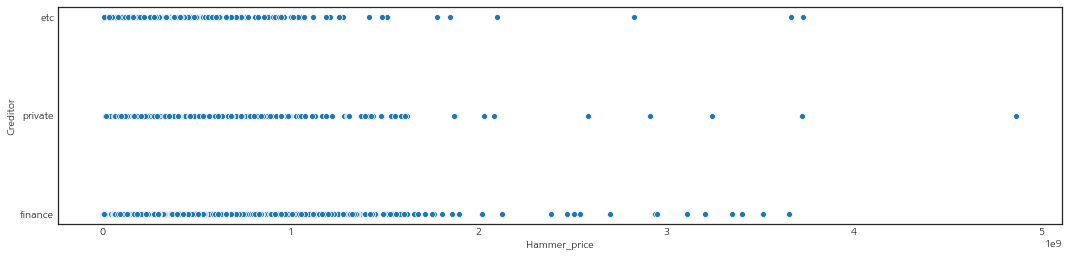

In [43]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="Creditor", x="Hammer_price")
plt.show()

그냥...다 비슷한데..?

### 1.18 addr_do

In [123]:
tr["addr_do"].value_counts() #???!?!?!?!? 서울 부산 두개 뿐이라고?!!?!? 와 대박

서울    1242
부산     691
Name: addr_do, dtype: int64

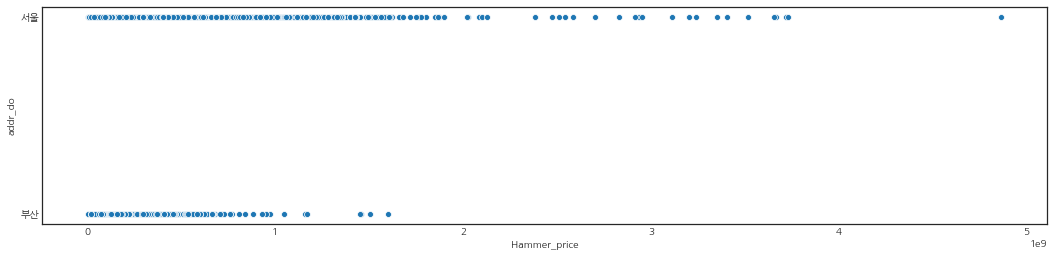

In [126]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="addr_do", x="Hammer_price")
plt.show()

이건 무조건 들어가야죠

### 1.19 addr_si

In [128]:
tr["addr_si"].value_counts() # 서울과 부산 뿐이면 구가 매우 중요해집니다. 구 이름이 겹치지 않으니까요

노원구     129
강남구     102
사하구      96
해운대구     89
부산진구     84
강서구      78
서초구      73
마포구      71
양천구      68
도봉구      68
송파구      60
사상구      58
구로구      57
남구       56
동대문구     53
은평구      53
북구       53
동래구      51
영등포구     47
성북구      45
관악구      43
강동구      39
동작구      37
중랑구      37
서대문구     37
수영구      33
연제구      31
중구       30
영도구      29
성동구      29
금정구      29
용산구      27
금천구      25
기장군      23
광진구      23
강북구      21
서구       17
종로구      17
동구       15
Name: addr_si, dtype: int64

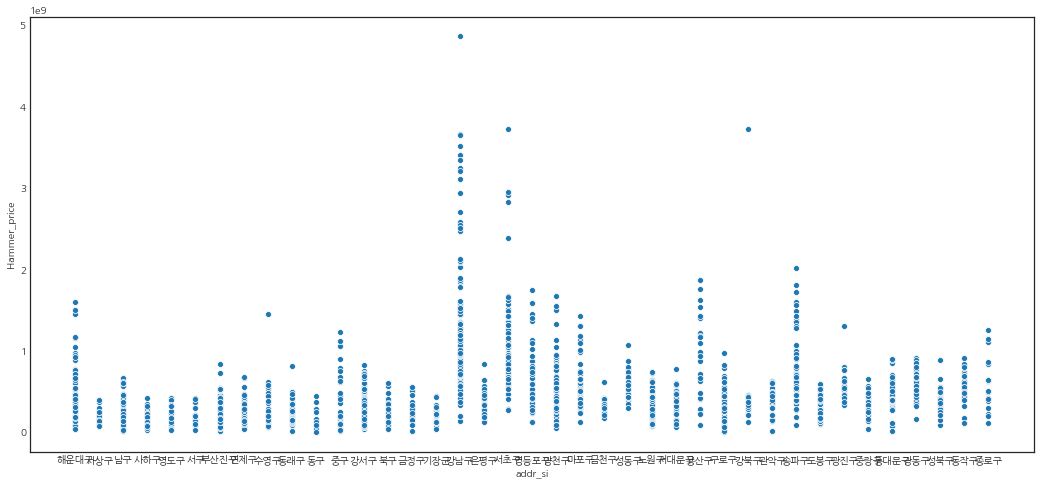

In [130]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,8))

sns.scatterplot(data=scatter, x="addr_si", y="Hammer_price")
plt.show()

라벨 인코딩으로 무조건 넣어주겠습니다. 의미가 매우 높습니다.

### 1.20 addr_dong

In [131]:
tr["addr_dong"].value_counts() # 동은 많네요.

상계동      52
아현동      32
서초동      32
화곡동      30
신정동      30
         ..
석관동       1
천왕동       1
홍익동       1
충무로4가     1
부평동4가     1
Name: addr_dong, Length: 285, dtype: int64

동과 리는 버리겠습니다.

In [133]:
tr.drop(["addr_dong", "addr_li"], axis=1, inplace=True)
tr.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Creditor,addr_do,addr_si,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,836000000,668800000,2018-02-13 00:00:00,2018-03-20 00:00:00,finance,부산,해운대구,N,1398.0,NaN,해운대엑소디움 5층 101-502호,주상복합,2009-07-14 00:00:00,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,1073000000,858400000,2016-12-29 00:00:00,2017-02-02 00:00:00,finance,부산,해운대구,N,1407.0,NaN,해운대두산위브더제니스 103동 51층 5103호,아파트,2011-12-16 00:00:00,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,119000000,76160000,2017-07-28 00:00:00,2017-10-13 00:00:00,finance,부산,사상구,N,552.0,NaN,백양그린 206동 14층 1403호,아파트,1992-07-31 00:00:00,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,288400000,230720000,2017-07-20 00:00:00,2017-11-02 00:00:00,finance,부산,남구,N,243.0,23.0,대연청구 109동 11층 1102호,아파트,2001-07-13 00:00:00,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,170000000,136000000,2016-07-06 00:00:00,2016-08-03 00:00:00,private,부산,사하구,N,399.0,2.0,동조리젠시 7층 703호,아파트,2001-11-27 00:00:00,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000


### 1.21 addr_san

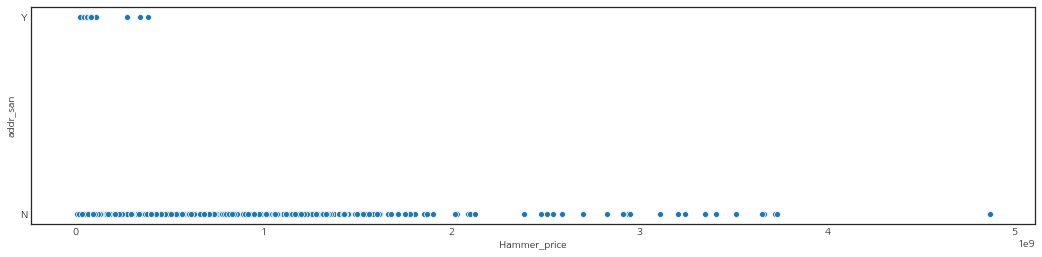

In [134]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="addr_san", x="Hammer_price")
plt.show()

In [136]:
tr["addr_san"].value_counts() # 산이 21개 밖에 되지 않는데, 아예 구분되는 데이터는 아닙니다. 다만 가격이 상대적으로 낮다는 것이죠.

N    1912
Y      21
Name: addr_san, dtype: int64

### 1.22 addr_bunji1

In [137]:
tr["addr_bunji1"].unique

<bound method Series.unique of 0       1398.0
1       1407.0
2        552.0
3        243.0
4        399.0
         ...  
1928      45.0
1929    1289.0
1930     208.0
1931     725.0
1932    1500.0
Name: addr_bunji1, Length: 1933, dtype: float64>

In [138]:
tr["addr_bunji2"].unique

<bound method Series.unique of 0        NaN
1        NaN
2        NaN
3       23.0
4        2.0
        ... 
1928     NaN
1929     NaN
1930     NaN
1931     NaN
1932     NaN
Name: addr_bunji2, Length: 1933, dtype: float64>

In [139]:
tr["addr_etc"].unique

<bound method Series.unique of 0                      해운대엑소디움 5층 101-502호
1               해운대두산위브더제니스 103동 51층 5103호
2                      백양그린 206동 14층 1403호
3                      대연청구 109동 11층 1102호
4                            동조리젠시 7층 703호
                       ...                
1928                     삼성 110동 15층 1501호
1929                 상계불암대림 205동 23층 2303호
1930    ,회현동2가 89 남산롯데캐슬아이리스 19층 102-1905호
1931                  삼성래미안 110동 11층 1102호
1932                   강서한강자이 106동 7층 703호
Name: addr_etc, Length: 1933, dtype: object>

셋 다 버리겠습니다.

In [140]:
tr.drop(["addr_bunji1", "addr_bunji2", "addr_etc"], axis=1, inplace=True)

### 1.23 Apartment_usage

In [141]:
tr["Apartment_usage"].value_counts()

아파트     1656
주상복합     277
Name: Apartment_usage, dtype: int64

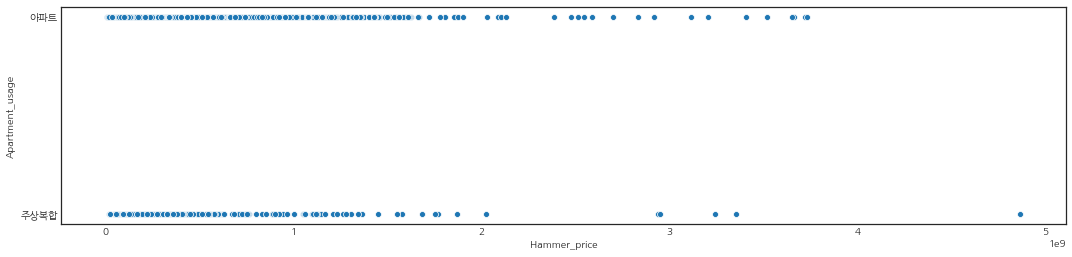

In [142]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="Apartment_usage", x="Hammer_price")
plt.show()

의외로 주상복합이 더 편차가 적습니다. 아웃라이어들이 많지만요.

### 1.24 Preserve_regist_date

In [143]:
tr["Preserve_regist_date"].value_counts() #  1111-11-11 은 뭐죠...? 등기일이라고요?

1111-11-11 00:00:00    43
1971-03-31 00:00:00    27
2012-02-10 00:00:00    12
2011-08-05 00:00:00     9
2008-12-02 00:00:00     7
                       ..
1988-11-17 00:00:00     1
2007-07-30 00:00:00     1
1988-04-21 00:00:00     1
1992-07-13 00:00:00     1
1984-10-24 00:00:00     1
Name: Preserve_regist_date, Length: 1256, dtype: int64

In [146]:
tr['Preserve_regist_date'] = pd.to_datetime(tr['Preserve_regist_date'], errors='coerce')
tr["Preserve_regist_year"] = tr["Preserve_regist_date"].dt.year
tr.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Creditor,addr_do,addr_si,addr_san,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price,Preserve_regist_year
0,2687,임의,개별,1766037301,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,836000000,668800000,2018-02-13 00:00:00,2018-03-20 00:00:00,finance,부산,해운대구,N,주상복합,2009-07-14,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,760000000,2009.0
1,2577,임의,일반,152946867,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,1073000000,858400000,2016-12-29 00:00:00,2017-02-02 00:00:00,finance,부산,해운대구,N,아파트,2011-12-16,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,971889999,2011.0
2,2197,임의,개별,11326510,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,119000000,76160000,2017-07-28 00:00:00,2017-10-13 00:00:00,finance,부산,사상구,N,아파트,1992-07-31,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,93399999,1992.0
3,2642,임의,일반,183581724,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,288400000,230720000,2017-07-20 00:00:00,2017-11-02 00:00:00,finance,부산,남구,N,아파트,2001-07-13,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,256899000,2001.0
4,1958,강제,일반,45887671,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,170000000,136000000,2016-07-06 00:00:00,2016-08-03 00:00:00,private,부산,사하구,N,아파트,2001-11-27,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,158660000,2001.0


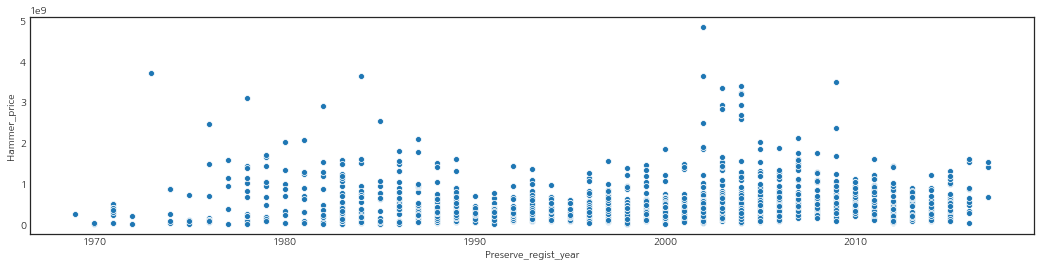

In [147]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, x="Preserve_regist_year", y="Hammer_price")
plt.show()

최초 등기일이라고 하면 아마도 준공년과 비슷할텐데, 오래된 건물일수록 단가가 낮지 않을까 하였습니다. 크게 관계는 없는듯 합니다.

### 1.25 Total_floor

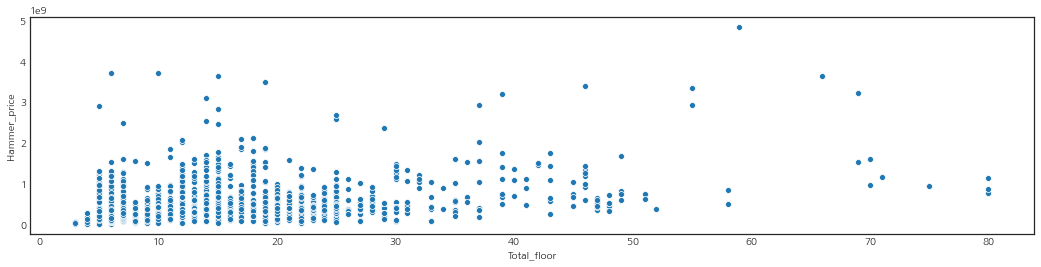

In [149]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, x="Total_floor", y="Hammer_price")
plt.show()

의외로 최고층수가 높다고 해서 가격이 높은 건 아닌 것 같습니다.

### 1.26 Current_floor

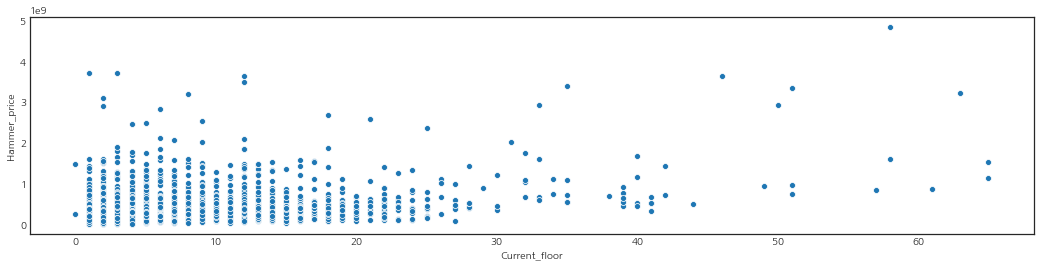

In [152]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, x="Current_floor", y="Hammer_price")
plt.show()

마찬가지입니다. 그러면 층수대비 고층여부를 파악해보면 어떨까요?

In [153]:
tr["floor_ratio"] = tr["Current_floor"] / tr["Total_floor"]

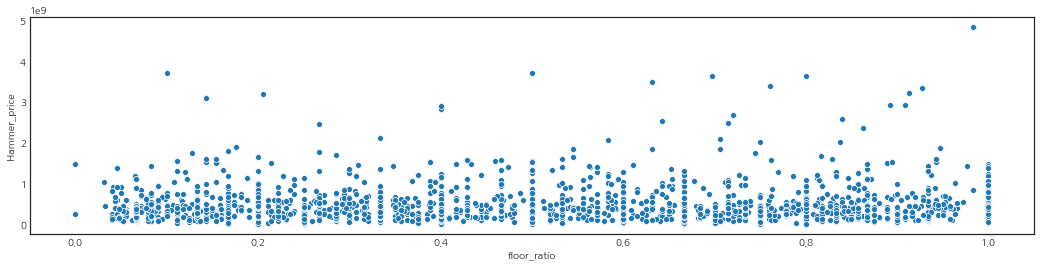

In [154]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, x="floor_ratio", y="Hammer_price")
plt.show()

네 전혀 의미 없어 보입니다.

### 1.27 Specific

In [156]:
tr["Specific"].value_counts() # 드랍입니다.

**1차감정: 220,000,000                                                                                                                                                                                                                                                                                                                               5
**1차감정: 240,000,000                                                                                                                                                                                                                                                                                                                               3
**1차감정:240,000,000                                                                                                                                                                                                                                                                                                              

In [157]:
tr["Specific"].isnull().sum()

1869

특이사항이 있는 곳과 없는 곳으로만 나눠서 비교해볼까요?

In [161]:
tr["Specific"] = tr["Specific"].fillna(value=0)

In [212]:
new_specific = []

for i in range(len(tr["Specific"])):
    if tr["Specific"][i] == 0:
        new_specific.append(0)
    else:
        new_specific.append(1)
        
tr["Specific"] = new_specific

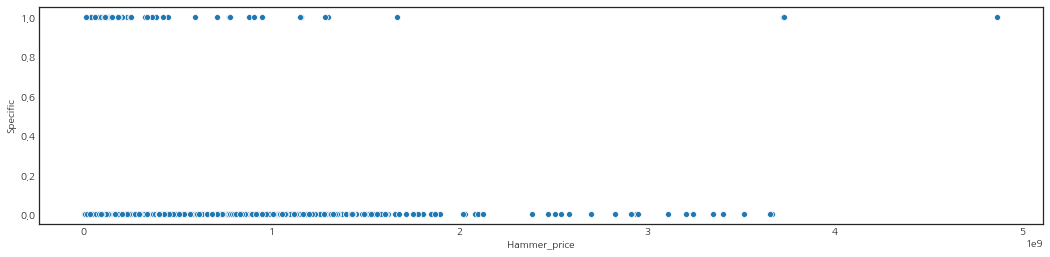

In [213]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="Specific", x="Hammer_price")
plt.show()

신기하게도 특이사항이 있는 곳이 편차가 더 작습니다.

### 1.28 Share_auction_YorN

In [215]:
tr["Share_auction_YorN"].value_counts() # 드랍입니다. 아닙니다.

N    1854
Y      79
Name: Share_auction_YorN, dtype: int64

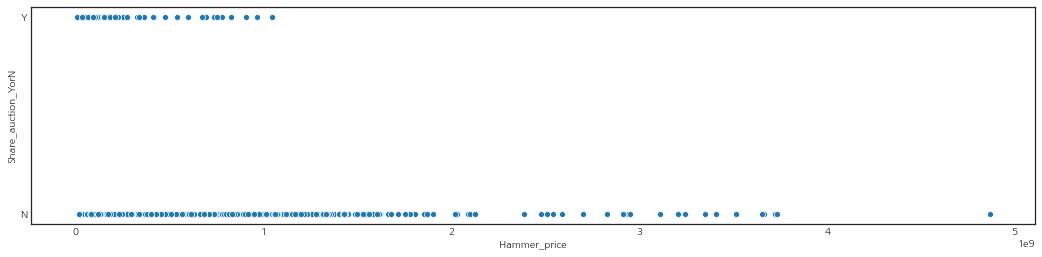

In [216]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, y="Share_auction_YorN", x="Hammer_price")
plt.show()

역시나 지분인 경우는 금액이 좀 더 작습니다.

### 1.29 road_name

In [217]:
tr["road_name"].unique # 어렵겠네요. 다 버리겠습니다.

<bound method Series.unique of 0           해운대해변로
1           마린시티2로
2         모라로110번길
3       황령대로319번가길
4              오작로
           ...    
1928        노해로66길
1929        덕릉로94길
1930           소공로
1931          우이천로
1932        양천로55길
Name: road_name, Length: 1933, dtype: object>

### 1.30 Close_date

In [218]:
tr["Close_date"].value_counts()

2016-09-08 00:00:00    37
2017-03-29 00:00:00    20
2018-02-28 00:00:00    19
2017-06-29 00:00:00    19
2017-12-28 00:00:00    17
                       ..
2017-11-28 00:00:00     1
2017-06-26 00:00:00     1
2017-10-12 00:00:00     1
2017-11-02 00:00:00     1
2017-08-16 00:00:00     1
Name: Close_date, Length: 389, dtype: int64

In [219]:
tr["Close_result"].value_counts() # 드랍더 비트

배당      1921
          12
Name: Close_result, dtype: int64

### 1.31  point.y / point.x

In [220]:
tr["point.y"] # 위도 경도는 0.01의 차이가 지하철역 1개 정도의 거리 차이다.

0       35.162717
1       35.156633
2       35.184601
3       35.154180
4       35.099630
          ...    
1928    37.648810
1929    37.663291
1930    37.558319
1931    37.647061
1932    37.566255
Name: point.y, Length: 1933, dtype: float64

In [221]:
tr["point.x"] # 그래서 이걸 소수점 2번째 자리에서 슬라이싱하고, 위도경도를 붙여서 라벨인코딩을 할 것이다.

0       129.137048
1       129.145068
2       128.996765
3       129.089081
4       128.998874
           ...    
1928    127.048683
1929    127.077063
1930    126.981994
1931    127.028002
1932    126.848961
Name: point.x, Length: 1933, dtype: float64

In [44]:
point_y = tr["point.y"].apply(lambda x: str(x)[:5])
point_x = tr["point.x"].apply(lambda x: str(x)[:6])

tr["point_xy"] = point_y+point_x

point_y = tr["point.y"].apply(lambda x: str(x)[:4])
point_x = tr["point.x"].apply(lambda x: str(x)[:5])

tr["point_xy2"] = point_y+point_x

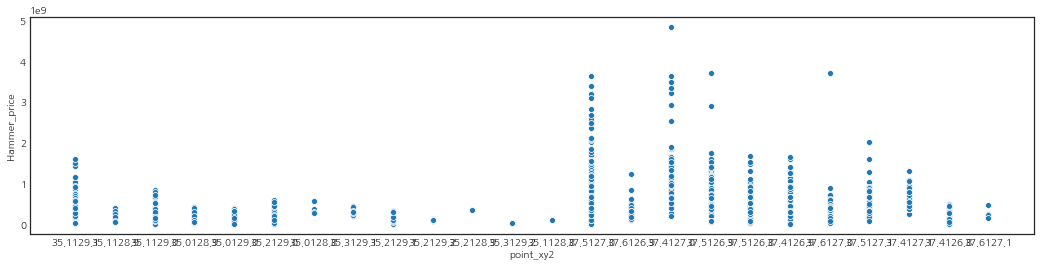

In [45]:
scatter = tr[tr["Hammer_price"] < 5000000000]

figure(figsize=(18,4))

sns.scatterplot(data=scatter, x="point_xy2", y="Hammer_price")
plt.show()

#### 자, 이제 어느 정도 칼럼을 쭉 둘러보았습니다. 
#### 이제 전처리, 파생변수생성, EDA를 깔끔하게 정리한 후 기본 칼럼과 파생변수 칼럼을 따로 구분해서 작업을 시작하겠습니다.
#### 기본변수를 통해서 모델을 선택하고,
#### 파생변수를 더해서 모델 최적값을 찾고, 피쳐 엔지니어링을 해주겠습니다.

### 1.99 전처리 정리

In [156]:
tr = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_master_train.csv")
te = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_master_test.csv")

In [157]:
# 1.15 First_auction_date, Final_auction_date # 차이 구하고 라벨링 및 카테고리화.
def pre_processing1(tr):
    tr['First_auction_date'] = pd.to_datetime(tr['First_auction_date'], errors='coerce')
    tr['Final_auction_date'] = pd.to_datetime(tr['Final_auction_date'], errors='coerce')
    tr["auction_period"] =  tr["Final_auction_date"] - tr["First_auction_date"]
    tr["auction_period"]= tr["auction_period"].astype(str)
    tr["auction_period"] = tr["auction_period"].apply(lambda x: x[:-24])
    tr["auction_period"]= tr["auction_period"].astype(int)
    new_auction_period = []
    for i in range(len(tr["auction_period"])):
        if tr["auction_period"][i] == 0:
            new_auction_period.append(0)
        elif tr["auction_period"][i] < 60:
            new_auction_period.append(1)
        else:
            new_auction_period.append(2)
    tr["new_auction_period"] = new_auction_period

# 1.17 Creditor #종류별로 카테고리화
    credit_slice =  tr["Creditor"].apply(lambda x: x[-2:])
    finance = ["은행", "재단", "대부", "농협", "피탈", "보험", "조합", "수협", "신협", "카드", "기금"]
    new_creditor = []
    for i in range(len(credit_slice)):
        if credit_slice[i] in finance:
            new_creditor.append("finance")
        elif credit_slice[i] == "te":
            new_creditor.append("private")
        else:
            new_creditor.append("etc")  
    tr["Creditor"] = new_creditor
    
# 1.24 Preserve_regist_date # 연도만 추출해서 라벨링.
    tr['Preserve_regist_date'] = pd.to_datetime(tr['Preserve_regist_date'], errors='coerce')
    tr["Preserve_regist_year"] = tr["Preserve_regist_date"].dt.year
    
# 1.27 Specific # 1과 0으로 변환   
    tr["Specific"] = tr["Specific"].fillna(value=0)
    new_specific =[]
    for i in range(len(tr["Specific"])):
        if tr["Specific"][i] == 0:
            new_specific.append(0)
        else:
            new_specific.append(1)
    tr["Specific"] = new_specific
    
# 1.31 point.xy
    point_y = tr["point.y"].apply(lambda x: str(x)[:5])
    point_x = tr["point.x"].apply(lambda x: str(x)[:6])
    tr["point_xy"] = point_y+point_x
    point_y = tr["point.y"].apply(lambda x: str(x)[:4])
    point_x = tr["point.x"].apply(lambda x: str(x)[:5])
    tr["point_xy2"] = point_y+point_x
    
    return tr

In [158]:
tr = pre_processing1(tr)
te = pre_processing1(te)

In [159]:
def pre_processing2(tr):
    tr.drop(["First_auction_date", "Final_auction_date", "Appraisal_company", "Auction_count", "Final_result", "Appraisal_date",
            "Total_land_gross_area", "Total_land_real_area", "Total_land_auction_area", "Total_building_area",
            "addr_bunji1", "addr_bunji2", "addr_etc", "addr_dong", "addr_li", "Total_floor", "Current_floor",
            "road_name", "Close_date", "Preserve_regist_date", "road_bunji1", "road_bunji2", "Close_result",
            "First_auction_date", "Final_auction_date", "point.x", "point.y"], axis=1, inplace=True)
    
    # 라벨 인코딩, 카테고리화
    le = LabelEncoder()
    le_columns = ["Auction_class", "Bid_class", "addr_do", "addr_si", "addr_san", "Apartment_usage",
                  "Share_auction_YorN", "Creditor", "new_auction_period", "Preserve_regist_year", "point_xy", "point_xy2"]
    for col in le_columns:
        tr[col] = le.fit_transform(tr[col])
        tr[col] = tr[col].astype('category')
        
    return tr

In [160]:
tr = pre_processing2(tr)
te = pre_processing2(te)

In [161]:
tr.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Auction_miscarriage_count,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,Creditor,addr_do,addr_si,addr_san,Apartment_usage,Specific,Share_auction_YorN,Hammer_price,auction_period,new_auction_period,Preserve_regist_year,point_xy,point_xy2
0,2687,1,0,1766037301,1,181.77,836000000,668800000,1,0,38,0,1,0,0,760000000,35,1,40,100,6
1,2577,1,2,152946867,1,118.38,1073000000,858400000,1,0,38,0,0,0,0,971889999,35,1,42,86,6
2,2197,1,0,11326510,2,49.94,119000000,76160000,1,0,20,0,0,0,0,93399999,77,2,23,122,4
3,2642,1,2,183581724,1,84.91,288400000,230720000,1,0,10,0,0,0,0,256899000,105,2,32,81,5
4,1958,0,2,45887671,1,84.96,170000000,136000000,2,0,21,0,0,0,0,158660000,28,1,32,25,1


In [162]:
tr.to_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_tr_pre.csv", index=False)
te.to_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_te_pre.csv", index=False)

In [180]:
tr = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_tr_pre.csv")
te = pd.read_csv(r"C:\Users\thinp\Desktop\Graduate School\Data\auction\Auction_te_pre.csv")

In [164]:
# 아주 높은 이상치 하나만 제외해줍니다.
tr = tr[tr["Hammer_price"] < 5000000000]

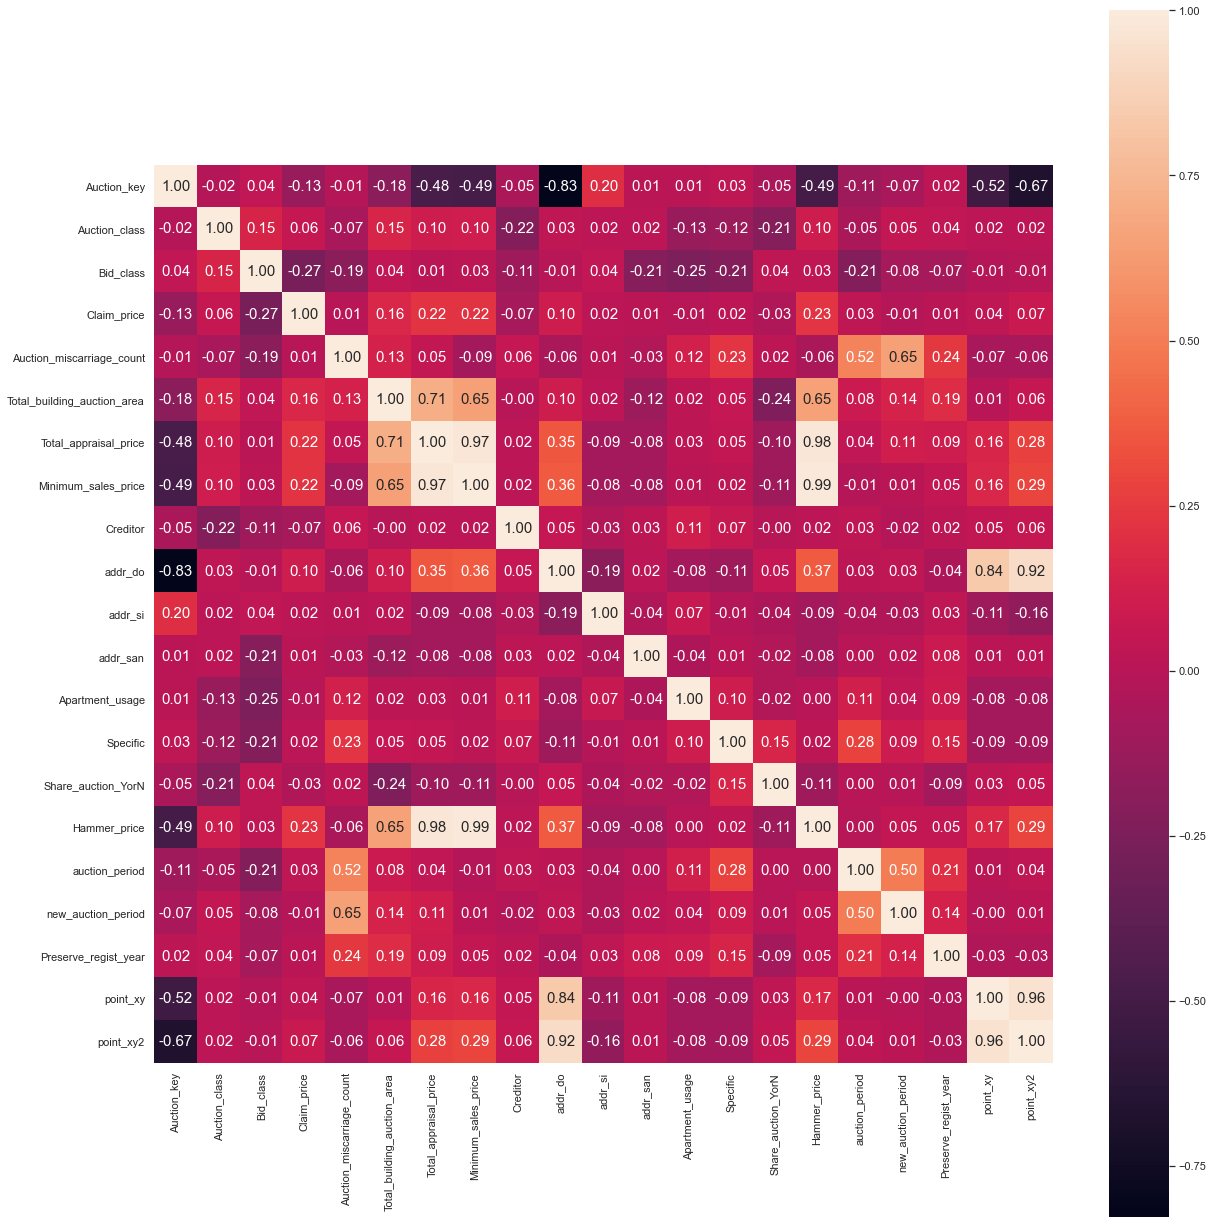

In [165]:
# feature 들의 상관 관계 분석하기
col = tr.columns

corr= tr.corr(method='pearson')

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothicOTF')
sns.set(font_scale=1.0)

figure(figsize=(18,18))
hm = sns.heatmap(corr.values,
                 cbar = True,
                 annot = True,
                 square = True,
                 fmt = '.2f',
                 annot_kws={'size':15},
                 yticklabels=col,
                 xticklabels=col)

plt.tight_layout()
plt.show()

# 2. 모델 선택

### 2.1 평가함수:RMSE

평가를 위해 RMSE 함수를 만들어줍니다.

In [166]:
def rmse(y_test, y_pred):
    error = y_test - y_pred
    error = error.apply(lambda x: x**2)
    mean = error.mean()
    score = np.sqrt(mean)
    
    return score

In [167]:
# tr로 샘플 돌려보겠습니다. 비율은 7:3 입니다.
x = tr[:1351]
y = tr[1351:]

x_train, y_train = x.loc[:, x.columns !="Hammer_price"], x["Hammer_price"]
x_test, y_test = y.loc[:, y.columns !="Hammer_price"], y["Hammer_price"]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1351, 20), (1351,), (581, 20), (581,))

### 2.2.1 LR

In [173]:
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

In [174]:
rmse(y_test, y_pred)

65809300.29536568

### 2.2.2 ElasticNet

In [142]:
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression

In [146]:
x_train, y_train = make_regression(random_state=42)
en_cv = ElasticNetCV(cv=5, random_state=42)
en_cv.fit(x_train, y_train)

print(en_cv.alpha_)
print(en_cv.l1_ratio)

0.19416079054904808
0.5


In [171]:
en = linear_model.ElasticNet(alpha=0.2,
                             l1_ratio=0.5,
                             random_state=42)
en.fit(x_train, y_train)
y_pred = en.predict(x_test)

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.188739783403537e+18, tolerance: 2.044986792618056e+16
  positive)


In [172]:
rmse(y_test, y_pred)

66134546.10791453

In [153]:
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100,200,500]
}
# Create a based model
rf = RandomForestRegressor(random_state=43) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(x_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

#해당 코드 실행시간 5분 소요

#{'max_features': 5,
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 200}

{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [168]:
# best_params_를 통해서 나온 값을 투입
rf_01 = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=500,
                           random_state=43,
                           n_jobs=-1)

rf_01.fit(x_train,y_train)
y_pred = rf_01.predict(x_test)

In [170]:
rmse(y_test, y_pred)

138274801.02092966

진짜로 돌려봅니다.

In [182]:
# 진짜로 돌려볼게요.
x_train, y_train = tr.loc[:, tr.columns !="Hammer_price"], tr["Hammer_price"]
x_test= te.loc[:, te.columns !="Hammer_price"]

x_train.shape, y_train.shape, x_test.shape

((1933, 20), (1933,), (829, 20), (581,))

In [190]:
lr_01 = linear_model.LinearRegression()
lr_01.fit(x_train, y_train)
y_pred = lr_01.predict(x_test)

te["Hammer_price"] = y_pred
te[["Auction_key", "Hammer_price"]].to_csv(r"C:\Users\thinp\python\Kaggle\_check_points\Dacon_RealEstate_LR_01.csv", index=False)

# 48,171,996 # 약 5천만원으로 줄였습니다.

In [215]:
lr_coef = pd.DataFrame(columns = ["Columns", "Coef"])
columns = []
coef = []
for i in range(len(x_train.columns)):
    columns.append(x_train.columns[i])
    coef.append(lr_01.coef_[i])


lr_coef["Columns"] = columns
lr_coef["Coef"] = coef
print(lr_01.coef_)

[-1.07974560e+04 -3.53302485e+06  7.25610189e+06  4.43809000e-03
  8.42298023e+06 -2.37645817e+05  3.28891323e-02  1.08112430e+00
  3.40236377e+05 -1.30848887e+07 -1.22757738e+05 -1.62687568e+07
 -1.22002375e+07  2.82250487e+06 -2.70890210e+07 -3.39379020e+04
  1.97397959e+07 -8.68447635e+04 -5.31484853e+04  1.91528969e+06]


In [216]:
lr_coef

,Columns,Coef
0,Auction_key,-1.079746e+04
1,Auction_class,-3.533025e+06
2,Bid_class,7.256102e+06
3,Claim_price,4.438090e-03
4,Auction_miscarriage_count,8.422980e+06
5,Total_building_auction_area,-2.376458e+05
6,Total_appraisal_price,3.288913e-02
7,Minimum_sales_price,1.081124e+00
8,Creditor,3.402364e+05
9,addr_do,-1.308489e+07


In [218]:
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.050e+04
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        16:08:53   Log-Likelihood:                -37121.
No. Observations:                1933   AIC:                         7.428e+04
Df Residuals:                    1912   BIC:                         7.440e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1.448e+07   1.12e+07      1.296      0.195   -7.43e+06    3.64e+07
Auction_key                  -1.08e+04   3475.025     -3.107      0.002   -1.76e+04   -3982.219
Auction_class               -3.533e+06   2.99e+06     -1.181      0.238    -9.4e+06    2.34e+06
Bid_class                    7.256e+06   2.87e+06      2.528      0.012    1.63e+06    1.29e+07
Claim_price                     0.0044      0.001      4.456      0.000       0.002       0.006
Auction_miscarriage_count    8.423e+06   2.26e+06      3.724      0.000    3.99e+06    1.29e+07
Total_building_auction_area -2.376e+05   3.86e+04     -6.156      0.000   -3.13e+05   -1.62e+05
Total_appraisal_price           0.0329      0.012      2.741      0.006       0.009       0.056
Minimum_sales_price             1.0811      0.014     79.285      0.000       1.054       1.108
Creditor                     3.402e+05   1.98e+06      0.172      0.864   -3.54e+06    4.22e+06
addr_do                     -1.308e+07   9.95e+06     -1.315      0.189   -3.26e+07    6.43e+06
addr_si                     -1.228e+05   1.13e+05     -1.083      0.279   -3.45e+05    9.95e+04
addr_san                    -1.627e+07   1.23e+07     -1.323      0.186   -4.04e+07    7.84e+06
Apartment_usage              -1.22e+07   3.68e+06     -3.319      0.001   -1.94e+07   -4.99e+06
Specific                     2.823e+06   7.54e+06      0.374      0.708    -1.2e+07    1.76e+07
Share_auction_YorN          -2.709e+07   6.63e+06     -4.086      0.000   -4.01e+07   -1.41e+07
auction_period              -3.394e+04      1e+04     -3.388      0.001   -5.36e+04   -1.43e+04
new_auction_period           1.974e+07   2.34e+06      8.425      0.000    1.51e+07    2.43e+07
Preserve_regist_year        -8.684e+04   1.12e+05     -0.779      0.436   -3.06e+05    1.32e+05
point_xy                    -5.315e+04   2.89e+04     -1.839      0.066    -1.1e+05    3540.383
point_xy2                    1.915e+06   9.78e+05      1.959      0.050   -1959.307    3.83e+06
==============================================================================
Omnibus:                     1409.656   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58256.717
Skew:                           2.953   Prob(JB):                         0.00
Kurtosis:                      29.238   Cond. No.                     1.57e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[Text(0, 0, 'const'),
 Text(0, 0, 'Auction_key'),
 Text(0, 0, 'Auction_class'),
 Text(0, 0, 'Bid_class'),
 Text(0, 0, 'Claim_price'),
 Text(0, 0, 'Auction_miscarriage_count'),
 Text(0, 0, 'Total_building_auction_area'),
 Text(0, 0, 'Total_appraisal_price'),
 Text(0, 0, 'Minimum_sales_price'),
 Text(0, 0, 'Creditor'),
 Text(0, 0, 'addr_do'),
 Text(0, 0, 'addr_si'),
 Text(0, 0, 'addr_san'),
 Text(0, 0, 'Apartment_usage'),
 Text(0, 0, 'Specific'),
 Text(0, 0, 'Share_auction_YorN'),
 Text(0, 0, 'auction_period'),
 Text(0, 0, 'new_auction_period'),
 Text(0, 0, 'Preserve_regist_year'),
 Text(0, 0, 'point_xy'),
 Text(0, 0, 'point_xy2')]

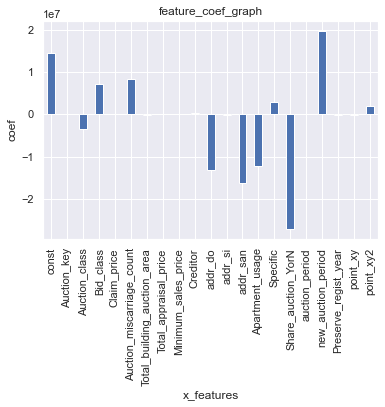

In [219]:
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

x_labels = model.params.index.tolist()

ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

In [221]:
# feature 마다의 VIF 계수를 출력한다.

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])] 
vif["features"] = x_train.columns
vif.round(1)

,VIF Factor,features
0,85.1,const
1,5.3,Auction_key
2,1.2,Auction_class
3,1.4,Bid_class
4,1.2,Claim_price
5,2.4,Auction_miscarriage_count
6,11.6,Total_building_auction_area
7,60.8,Total_appraisal_price
8,32.1,Minimum_sales_price
9,1.1,Creditor


In [191]:
param_grid = {
    'max_features': [2,3,5],
    'min_samples_leaf': [2,3],
    'min_samples_split': [2,4,6],
    'n_estimators': [100,200,500]
}
# Create a based model
rf = RandomForestRegressor(random_state=43) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(x_train, y_train)

grid_search.best_params_ #학습 이후 최적의 paramter를 출력

#해당 코드 실행시간 5분 소요

{'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [192]:
# best_params_를 통해서 나온 값을 투입
RF_001 = RandomForestRegressor(max_features=5,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=200,
                           random_state=43,
                           n_jobs=-1)

RF_001.fit(x_train,y_train)
y_pred = RF_001.predict(x_test)
te["Hammer_price"] = y_pred
te[["Auction_key", "Hammer_price"]].to_csv(r"C:\Users\thinp\python\Kaggle\_check_points\Dacon_RealEstate_RF_001.csv", index=False)

# 59,694,160 # 6천만원. LR보다 성과가 좋지 않습니다.

In [196]:
param_grid = {
    'max_depth': [2,3,4],
    'learning_rate': [0.3, 0.5 ,0.7],
    'n_estimators': [100,200,300]
}
# Create a based model
gbr = GradientBoostingRegressor(random_state=44) # 랜덤포레스트 모델을 정의한다.
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid) # GridSearchCV를 정의한다.

grid_search.fit(x_train, y_train)
grid_search.best_params_ #학습 이후 최적의 paramter를 출력

#해당 코드 실행시간 5분 소요

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}

In [198]:
gbrt_01 = GradientBoostingRegressor(max_depth = 3,
                                     n_estimators= 100,
                                     learning_rate=0.5,)
gbrt_01.fit(x_train,y_train)
y_pred = gbrt_01.predict(x_test)
te["Hammer_price"] = y_pred
te[["Auction_key", "Hammer_price"]].to_csv(r"C:\Users\thinp\python\Kaggle\_check_points\Dacon_RealEstate_gbrt_01.csv", index=False)

# 256,631,985 # 2억 6천?!?!